In [1]:
!pip install qiskit qiskit-aer matplotlib pandas numpy tensorflow pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 138.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 159.0 MB/s eta 0:00:00


This notebook demonstrates a novel approach to stock price prediction using a combination of classical Convolutional Neural Networks (CNNs) and a Quantum Layer, leveraging Quantum Gramian Angular Fields (QGAF) for data encoding. The goal is to predict the 'Close' price of a stock, ensuring the prediction stays within the actual 'Low' and 'High' bounds of the day.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import pennylane as qml
import os

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [117]:
TRAIN_PATH = "X_train.csv"
TEST_PATH  = "X_test.csv"
FEATS = ['Open','High','Low','Volume']
WIN_N = 15 # Window size for QGAF image generation
EPOCHS = 80
BATCH  = 16
SEED   = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

# Quantum Layer Parameters
N_QUBITS = 8
N_LAYERS = 3
PI = tf.constant(3.141592653589793, tf.float32)

In [109]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# Convert Date column to datetime and sort
for df in [train_df, test_df]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)

print("Training Data Head:")
print(train_df.head())
print("\nTesting Data Head:")
print(test_df.head())

Training Data Head:
        Date     Open     High      Low    Close        Volume
0 2025-01-02  5903.26  5935.09  5829.53  5868.55  2.248974e+09
1 2025-01-03  5891.07  5949.34  5888.66  5942.47  2.208966e+09
2 2025-01-06  5982.81  6021.04  5960.01  5975.38  2.825734e+09
3 2025-01-07  5993.26  6000.68  5890.68  5909.03  2.695893e+09
4 2025-01-08  5910.66  5927.89  5874.78  5918.25  2.552763e+09

Testing Data Head:
        Date     Open     High      Low        Volume
0 2025-09-02  6401.51  6416.54  6360.58  2.887743e+09
1 2025-09-03  6445.82  6453.67  6416.17  2.808411e+09
2 2025-09-04  6456.60  6502.54  6445.98  2.747907e+09
3 2025-09-05  6529.08  6532.65  6443.98  3.166204e+09
4 2025-09-08  6498.09  6508.67  6483.29  3.028552e+09


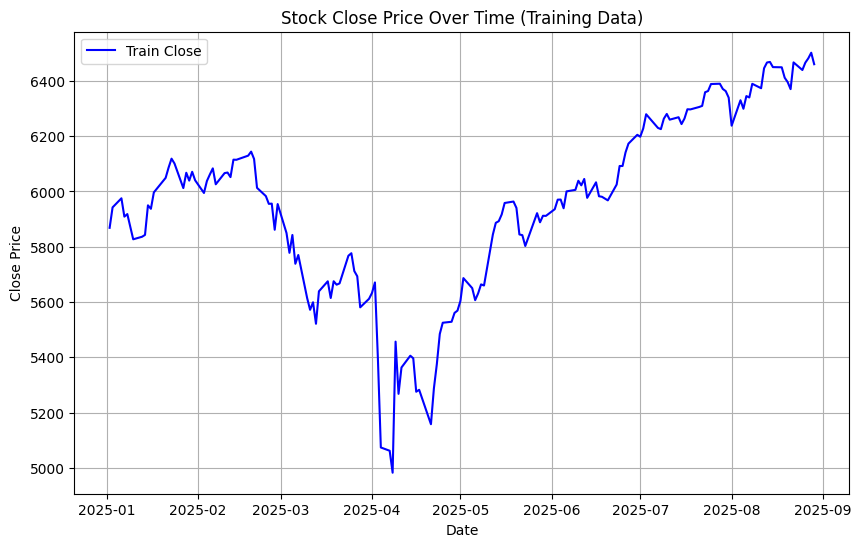

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(train_df['Date'], train_df['Close'], label='Train Close', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Close Price Over Time (Training Data)')
plt.legend()
plt.grid(True)
plt.show()

##Quantum Gramian Angular Field (QGAF) Utilities

In [118]:
def compute_phi_global(vec):
    """
    Transforms a standardized vector into angles for QGAF.
    Maps values from [-1, 1] to [0, 1] using tanh, then to [0, pi] using arccos.
    """
    z = np.tanh(vec)          # [-1,1]
    z = (z + 1.0) / 2.0       # [0,1]
    return np.arccos(z)       # [0,π]

def qgaf(phi, difference=False):
    """
    Computes the Gramian Angular Field matrix.
    Args:
        phi (np.array): A vector of angles (in radians).
        difference (bool): If True, computes QGADF (difference field),
                           else computes QGASF (summation field).
    Returns:
        np.array: The QGAF matrix.
    """
    if difference:
        return np.cos(np.subtract.outer(phi, phi))  # QGADF
    return np.cos(np.add.outer(phi, phi))           # QGASF

def build_images(df, scaler, win):
    """
    Builds QGAF images (QGASF and QGADF) for a given DataFrame.
    """
    Xstd = scaler.transform(df[FEATS].to_numpy())
    A, B = [], [] # A for QGASF, B for QGADF
    for i in range(win, len(df)):
        # Select a window of data and flatten it
        block = Xstd[i-win:i, :].reshape(-1) # win * len(FEATS)
        phi = compute_phi_global(block)
        A.append(qgaf(phi, difference=False)) # QGASF
        B.append(qgaf(phi, difference=True))  # QGADF
    return np.stack(A), np.stack(B)

def build_test_images_with_history(train_df, test_df, scaler, win):
    """
    Builds QGAF images for the test set, incorporating historical data from the training set.
    This ensures that the test set images are generated using a sliding window that
    can extend into the end of the training data.
    """
    # Get the last 'win' rows of training features for the initial history
    hist = train_df[FEATS].tail(win).to_numpy(dtype=np.float32)
    A, B = [], []
    for i in range(len(test_df)):
        # Features from the test set up to the current point
        test_seen = test_df[FEATS].iloc[:i].to_numpy(dtype=np.float32)
        # Combine history and currently seen test data, take the last 'win' rows
        window = np.vstack([hist, test_seen])[-win:, :] # (win, len(FEATS))
        window_std = scaler.transform(window)
        vec = window_std.reshape(-1)
        phi = compute_phi_global(vec)
        A.append(qgaf(phi, difference=False))
        B.append(qgaf(phi, difference=True))
    return np.stack(A), np.stack(B)



*   **compute_phi_global(vec)**: This function takes a standardized vector of financial features. It first squashes the values to [-1, 1] using tanh, then scales them to [0, 1], and finally transforms them into angles [0, π] using arccos. These angles are crucial for the GAF transformation.
*   **qgaf(phi, difference=False)**: This is the heart of the GAF generation. It takes the angles phi and computes either the Gramian Angular Summation Field (GASF) or the Gramian Angular Difference Field (GADF). GAFs essentially encode the time series as an image by considering the pairwise relationships between data points in polar coordinates. The np.subtract.outer and np.add.outer operations create the outer product of phi with itself, allowing the cosine function to generate the GAF matrix.
*   **build_images(df, scaler, win)**: This function iterates through a DataFrame, applying a sliding window of size win. For each window, it standardizes the FEATS data, flattens it into a vector, converts it to angles, and then generates both QGASF and QGADF images. These images capture temporal dependencies in a spatial representation.
*   **build_test_images_with_history(train_df, test_df, scaler, win)**: This specialized function handles the generation of test set images. It's designed to correctly incorporate the WIN_N previous data points by taking the tail of the training data, allowing for a continuous windowing effect as the test data is processed sequentially. This prevents information leakage while ensuring the test images are contextually relevant.






##Data Preprocessing and QGAF Image Generation

In [119]:
# Data scaling
scaler = StandardScaler().fit(train_df[FEATS].to_numpy())

# Build training QGAF images
print(f"Building QGAF images for training data with window size {WIN_N}...")
QGASF_tr, QGADF_tr = build_images(train_df, scaler, WIN_N)
print(f"Shape of QGASF_tr: {QGASF_tr.shape}")
print(f"Shape of QGADF_tr: {QGADF_tr.shape}")

# Build testing QGAF images with history
print(f"Building QGAF images for testing data with window size {WIN_N} and training history...")
QGASF_te, QGADF_te = build_test_images_with_history(train_df, test_df, scaler, WIN_N)
print(f"Shape of QGASF_te: {QGASF_te.shape}")
print(f"Shape of QGADF_te: {QGADF_te.shape}")

# Stack QGASF and QGADF to create a 2-channel image input for the CNN
X_train = np.stack((QGASF_tr, QGADF_tr), axis=-1).astype('float32')
X_test  = np.stack((QGASF_te, QGADF_te), axis=-1).astype('float32')
img_side = X_train.shape[1]

print(f"\nFinal X_train shape (samples, img_height, img_width, channels): {X_train.shape}")
print(f"Final X_test shape (samples, img_height, img_width, channels): {X_test.shape}")
print(f"Image side length: {img_side}")

# Prepare targets and auxiliary inputs for bounds
close_tr = train_df['Close'].iloc[WIN_N:].to_numpy('float32')
low_tr   = train_df['Low'  ].iloc[WIN_N:].to_numpy('float32')
high_tr  = train_df['High' ].iloc[WIN_N:].to_numpy('float32')
aux_tr   = np.stack([low_tr, high_tr], axis=1).astype('float32')

# Time split for validation
# Using the defined VALIDATION_SPLIT_RATIO
split = int(VALIDATION_SPLIT_RATIO * len(close_tr)) # <<<<< MODIFIED: Using config variable
X_tr, y_tr, aux_tr_in = X_train[:split], close_tr[:split], aux_tr[:split]
X_va, y_va, aux_va_in = X_train[split:], close_tr[split:], aux_tr[split:]

print(f"\nTraining split shapes: X_tr {X_tr.shape}, y_tr {y_tr.shape}, aux_tr_in {aux_tr_in.shape}")
print(f"Validation split shapes: X_va {X_va.shape}, y_va {y_va.shape}, aux_va_in {aux_va_in.shape}")

# Assertions to catch potential data issues early (added robustness)
assert len(X_tr) == len(y_tr) == len(aux_tr_in), "Mismatch in training data sizes!"
assert len(X_va) == len(y_va) == len(aux_va_in), "Mismatch in validation data sizes!"
assert X_tr.ndim == 4 and X_tr.shape[-1] == 2, "X_tr has incorrect dimensions or channels."
assert X_va.ndim == 4 and X_va.shape[-1] == 2, "X_va has incorrect dimensions or channels."

Building QGAF images for training data with window size 15...
Shape of QGASF_tr: (150, 60, 60)
Shape of QGADF_tr: (150, 60, 60)
Building QGAF images for testing data with window size 15 and training history...
Shape of QGASF_te: (10, 60, 60)
Shape of QGADF_te: (10, 60, 60)

Final X_train shape (samples, img_height, img_width, channels): (150, 60, 60, 2)
Final X_test shape (samples, img_height, img_width, channels): (10, 60, 60, 2)
Image side length: 60

Training split shapes: X_tr (120, 60, 60, 2), y_tr (120,), aux_tr_in (120, 2)
Validation split shapes: X_va (30, 60, 60, 2), y_va (30,), aux_va_in (30, 2)


###This cell performs the crucial data transformation steps:

1. Standardization: A StandardScaler is fitted only on the training data's features. This scaler is then used to transform both training and testing features to prevent data leakage from the test set.
2. QGAF Image Generation: The build_images and build_test_images_with_history functions are called to create the QGASF and QGADF image arrays for both training and testing sets.
3. Image Stacking: The QGASF and QGADF arrays are stacked along a new axis to form a 2-channel input for the CNN. This is analogous to an RGB image but with two channels representing different aspects of the time series (summation and difference).
4. Target and Auxiliary Data Preparation: The 'Close' prices (our target variable y) are extracted, starting from WIN_N because the first WIN_N data points are used to form the first image, so their corresponding 'Close' values are not directly predicted by an image. Similarly, 'Low' and 'High' prices are extracted to serve as auxiliary inputs (aux_tr) for the model's output bounding mechanism.
5. Time-Based Split: The training data (QGAF images, targets, and auxiliary inputs) is split into training and validation sets using an 80/20 time-based split. This is essential for evaluating the model's generalization performance on unseen future data.

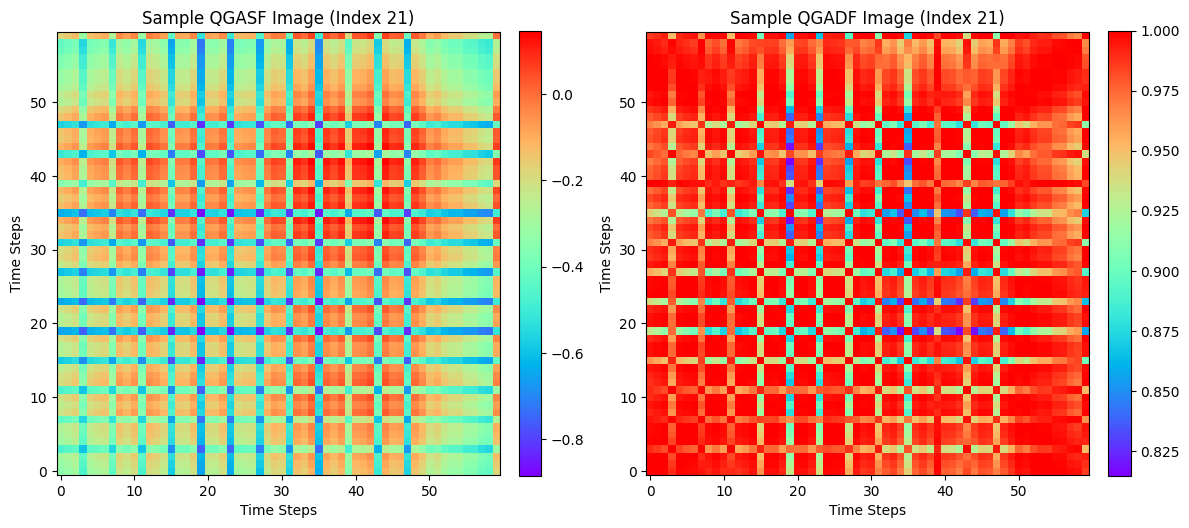

In [120]:
# Select a sample index from the training data
sample_index = 21

# Get the QGAF images for the selected sample
sample_qgasf = X_train[sample_index, :, :, 0]
sample_qgadf = X_train[sample_index, :, :, 1]

# Display the QGAF images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im0 = axes[0].imshow(sample_qgasf, cmap='rainbow', origin='lower')
axes[0].set_title(f'Sample QGASF Image (Index {sample_index})')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Time Steps')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)


im1 = axes[1].imshow(sample_qgadf, cmap='rainbow', origin='lower')
axes[1].set_title(f'Sample QGADF Image (Index {sample_index})')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Time Steps')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

##Quantum Layer Definition (PennyLane & TensorFlow)

In [121]:
LEARNING_RATE = 1e-3
VALIDATION_SPLIT_RATIO = 0.8
EARLY_STOPPING_PATIENCE = 15
LR_REDUCTION_PATIENCE = 7

In [122]:
# ---------------------------
# Quantum layer (works with TF backprop)
# ---------------------------
DEV = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(DEV, interface="tensorflow", diff_method="backprop")
def qnode_tf(angles, weights):
    """
    Pennylane QNode defining the quantum circuit.
    Args:
        angles (tf.Tensor): Input angles to the quantum circuit, mapped from CNN output.
                            Shape: (N_QUBITS,)
        weights (tf.Tensor): Trainable weights for the quantum circuit layers.
                             Shape: (N_LAYERS, N_QUBITS, 3)
    Returns:
        list: Expectation values of PauliZ for each qubit.
    """
    # Apply input angles as RY rotations
    for i in range(N_QUBITS):
        qml.RY(angles[i], wires=i)
    # Apply a strongly entangling layer with trainable weights
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    # Measure expectation values of PauliZ for each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

class QuantumLayer(tf.keras.layers.Layer):
    """
    A Keras Layer that wraps the Pennylane QNode, allowing it to be integrated
    seamlessly into a TensorFlow Keras model.
    """
    def build(self, input_shape):
        # Define trainable weights for the quantum circuit
        self.w = self.add_weight(
            name="weights",
            shape=(N_LAYERS, N_QUBITS, 3), # (layers, qubits, params_per_layer_qubit)
            initializer="glorot_uniform",
            dtype=tf.float32,
            trainable=True,
        )
        super(QuantumLayer, self).build(input_shape)

    def call(self, inputs):
        # Ensure inputs and weights are tf.float32
        inputs = tf.cast(inputs, tf.float32)     # (batch, N_QUBITS)
        w = tf.cast(self.w, tf.float32)

        # Map the QNode execution over each sample in the batch
        def single(sample):
            out = qnode_tf(sample, w)            # (N_QUBITS,)
            return tf.cast(out, tf.float32)

        # Use tf.map_fn for batch processing on the quantum circuit
        out = tf.map_fn(single, inputs, fn_output_signature=tf.float32)  # (batch, N_QUBITS)
        out.set_shape((None, N_QUBITS)) # Set shape for Keras compatibility
        return out

    def compute_output_shape(self, input_shape):
        # Output shape is (batch_size, N_QUBITS) as each qubit is measured
        return (input_shape[0], N_QUBITS)

* **Input Encoding**: qml.RY(angles[i], wires=i applies an RY rotation to each qubit, with the angle determined by the input angles from the classical network. This encodes information from the classical features into the quantum state.
* **Quantum Processing**: qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS)) adds trainable, strongly entangling layers. These layers contain rotation gates and CNOT gates (or similar entangling operations) which allow for complex quantum computations and feature mapping. The weights for these layers are learned during the training process.
* **Measurement**: qml.expval(qml.PauliZ(i)) measures the expectation value of the Pauli-Z operator for each qubit. These expectation values are classical outputs that are passed back to the classical neural network.

* **class QuantumLayer(tf.keras.layers.Layer)**: This custom Keras layer wraps the PennyLane QNode.
1.  build(self, input_shape): This method initializes the trainable weights for the StronglyEntanglingLayers within the quantum circuit.
2.  call(self, inputs): This method defines the forward pass of the layer. It takes the classical output from the previous CNN layers, scales it to be used as angles, and then calls the qnode_tf for each sample in the batch using tf.map_fn. The outputs from the quantum circuit are then returned to the classical network.

##Model Architecture Definition (Hybrid CNN-Quantum Model)

In [123]:
# ---------------------------
# Model: CNN -> angles[-π,π] -> Quantum -> Dense -> Bounded delta head
# ---------------------------
def build_model(img_side: int) -> tf.keras.Model:
    """
    Builds the hybrid classical-quantum model for stock price prediction.
    """
    img_in = layers.Input(shape=(img_side, img_side, 2), name="img_in")
    aux_in = layers.Input(shape=(2,), name="aux_in")  # [Low, High] for output bounding

    # 1. Classical CNN Feature Extractor
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(img_in)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # 2. Input to Quantum Layer (Angles scaled to [-π, π])
    # The output of the classical CNN is mapped to 'N_QUBITS' angles
    x = layers.Dense(N_QUBITS, activation='tanh')(x) # Output in [-1, 1]
    x = layers.Lambda(lambda t: t * PI, name="angle_scale")(x) # Scale to [-π, π]

    # 3. Quantum Layer
    x = QuantumLayer(name="qml_block")(x)
    x = layers.Dense(64, activation='relu')(x) # Further classical processing post-quantum

    # 4. Bounded Delta Head for Prediction
    # This head ensures the prediction stays within the actual High-Low range.
    low  = layers.Lambda(lambda t: t[:, 0:1], name="low_slice")(aux_in)
    high = layers.Lambda(lambda t: t[:, 1:1+1], name="high_slice")(aux_in)
    mid  = layers.Lambda(lambda t: 0.5*(t[0] + t[1]), name="mid")([low, high])
    half_spread = layers.Lambda(lambda t: 0.5*(t[1] - t[0]), name="half_spread")([low, high])

    # Predict a delta value in [-1, 1] relative to the mid-price
    delta_raw = layers.Dense(1, activation='tanh', name='delta_raw')(x)

    # Scale the delta by the actual half-spread to get a bounded prediction
    delta_bounded = layers.Multiply(name="delta_scaled")([half_spread, delta_raw])
    # Apply a 10% safety margin to ensure strict bounds
    delta_bounded = layers.Lambda(lambda t: 0.99*t, name="margin")(delta_bounded)
    y_hat = layers.Add(name="close_hat")([mid, delta_bounded]) # Final predicted Close

    m = models.Model(inputs=[img_in, aux_in], outputs=y_hat)

    # Optional R^2 metric for evaluation
    class RSquared(tf.keras.metrics.Metric):
        def __init__(self, name="r2", **kwargs):
            super().__init__(name=name, **kwargs)
            self.sse = self.add_weight(name="sse", initializer="zeros")
            self.sst = self.add_weight(name="sst", initializer="zeros")
        def update_state(self, y_true, y_pred, sample_weight=None):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)
            err = y_true - y_pred
            self.sse.assign_add(tf.reduce_sum(tf.square(err)))
            mean = tf.reduce_mean(y_true)
            self.sst.assign_add(tf.reduce_sum(tf.square(y_true - mean)))
        def result(self):
            return 1.0 - (self.sse / (self.sst + 1e-12))
        def reset_states(self):
            for v in (self.sse, self.sst):
                tf.keras.backend.set_value(v, 0.0)

    m.compile(
        optimizer=optimizers.Adam(1e-3),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), RSquared()]
    )
    return m

# Build and display model summary
model = build_model(img_side)
model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_in (InputLayer) │ (None, 60, 60, 2) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 60, 60,    │        608 │ img_in[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 30, 30,    │          0 │ conv2d_75[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 30, 30,    │     18,496 │ max_pooling2d_54… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_55    │ (None, 15, 15,    │          0 │ conv2d_76[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 15, 15,    │     73,856 │ max_pooling2d_55… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 28800)     │          0 │ conv2d_77[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 128)       │  3,686,528 │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_83[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 8)         │      1,032 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ angle_scale         │ (None, 8)         │          0 │ dense_84[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_in (InputLayer) │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ qml_block           │ (None, 8)         │         72 │ angle_scale[0][0] │
│ (QuantumLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ low_slice (Lambda)  │ (None, 1)         │          0 │ aux_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ high_slice (Lambda) │ (None, 1)         │          0 │ aux_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 64)        │        576 │ qml_block[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ half_spread         │ (None, 1)         │          0 │ low_slice[0][0],  │
│ (Lambda)            │                   │            │ high_slice[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_raw (Dense)   │ (None, 1)         │         65 │ dense_85[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_scaled        │ (None, 1)         │          0 │ half_spread[0][0… │
│ (Multiply)          │                   │            │ delta_raw[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,781,233 (14.42 MB)

 Trainable params: 3,781,233 (14.42 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# Callbacks for robust training
cbs = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

# Ensure input types are correct before training
assert X_tr.ndim == 4 and X_tr.shape[-1] == 2
assert X_va.ndim == 4 and X_va.shape[-1] == 2
X_tr = X_tr.astype('float32'); X_va = X_va.astype('float32')
aux_tr_in = aux_tr_in.astype('float32'); aux_va_in = aux_va_in.astype('float32')

print("Starting model training...")
history = model.fit(
    {'img_in': X_tr, 'aux_in': aux_tr_in}, y_tr,
    validation_data=({'img_in': X_va, 'aux_in': aux_va_in}, y_va),
    epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=1
)
print("Model training complete.")

Starting model training...
Epoch 1/80


/tmp/ipython-input-3476927912.py:49: PennyLaneDeprecationWarning: Support for the TensorFlow interface is deprecated and will be removed in v0.44. Future versions of PennyLane are not guaranteed to work with TensorFlow. Please migrate your workflows to JAX or Pytorch to benefit from enhanced support and features.
  out = qnode_tf(sample, w)            # (N_QUBITS,)


8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - loss: 1024.9158 - r2: -30.1060 - rmse: 31.6091 - val_loss: 334.5677 - val_r2: -29.0158 - val_rmse: 18.2912 - learning_rate: 0.0010
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 1028.4805 - r2: -29.8517 - rmse: 31.3701 - val_loss: 329.5679 - val_r2: -28.9907 - val_rmse: 18.1540 - learning_rate: 0.0010
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 974.0028 - r2: -29.9195 - rmse: 30.5708 - val_loss: 314.4728 - val_r2: -28.9322 - val_rmse: 17.7334 - learning_rate: 0.0010
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 938.4426 - r2: -29.9477 - rmse: 30.0707 - val_loss: 311.7139 - val_r2: -28.9242 - val_rmse: 17.6554 - learning_rate: 0.0010
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 918.8154 - r2: -29.9828 - rmse: 29.7141 - val_loss: 312.3565 - val_r2: -28.9260 - val_rmse: 17.6736 - learning_rate: 0.0010
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 931.8210 - r2: -29.9762 - rmse: 29.9655 

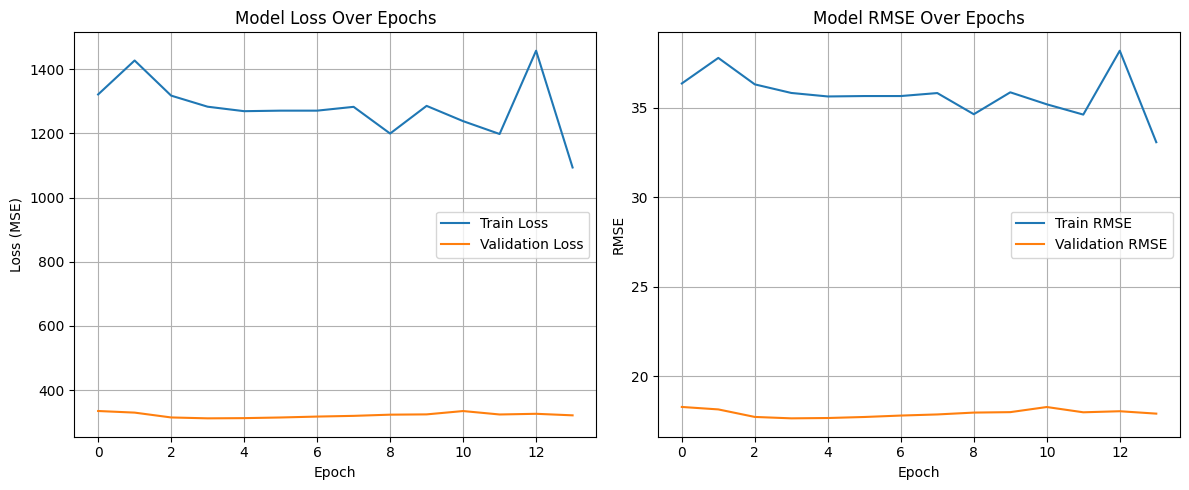

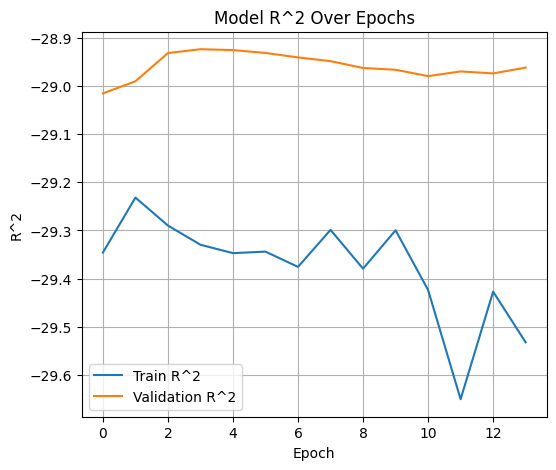

In [125]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot training & validation RMSE values
plt.subplot(1, 2, 2)
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Plot R^2 if it was included in metrics
if 'r2' in history.history:
    plt.figure(figsize=(6, 5))
    plt.plot(history.history['r2'], label='Train R^2')
    plt.plot(history.history['val_r2'], label='Validation R^2')
    plt.title('Model R^2 Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('R^2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [126]:
# Prepare test auxiliary inputs
dates_te = test_df['Date'].reset_index(drop=True)
low_te   = test_df['Low' ].to_numpy('float32')
high_te  = test_df['High'].to_numpy('float32')
aux_te   = np.stack([low_te, high_te], axis=1).astype('float32')

print("Making predictions on the test set...")
y_hat_close = model.predict({'img_in': X_test.astype('float32'), 'aux_in': aux_te}, verbose=0).reshape(-1)
print(f"Predictions made for {len(y_hat_close)} test samples.")

# Save predictions to CSV
pred_df = pd.DataFrame({'Date': dates_te, 'Predicted_Close': y_hat_close})
pred_df.to_csv('predicted_close.csv', index=False)
print("Saved predicted_close.csv:", len(pred_df), "rows")

# Display a sample of predictions
print("\nSample of Predicted Close Prices:")
print(pred_df.head())

Making predictions on the test set...


/tmp/ipython-input-3476927912.py:49: PennyLaneDeprecationWarning: Support for the TensorFlow interface is deprecated and will be removed in v0.44. Future versions of PennyLane are not guaranteed to work with TensorFlow. Please migrate your workflows to JAX or Pytorch to benefit from enhanced support and features.
  out = qnode_tf(sample, w)            # (N_QUBITS,)


Predictions made for 10 test samples.
Saved predicted_close.csv: 10 rows

Sample of Predicted Close Prices:
        Date  Predicted_Close
0 2025-09-02      6396.140137
1 2025-09-03      6439.999512
2 2025-09-04      6481.921387
3 2025-09-05      6500.326172
4 2025-09-08      6499.417969


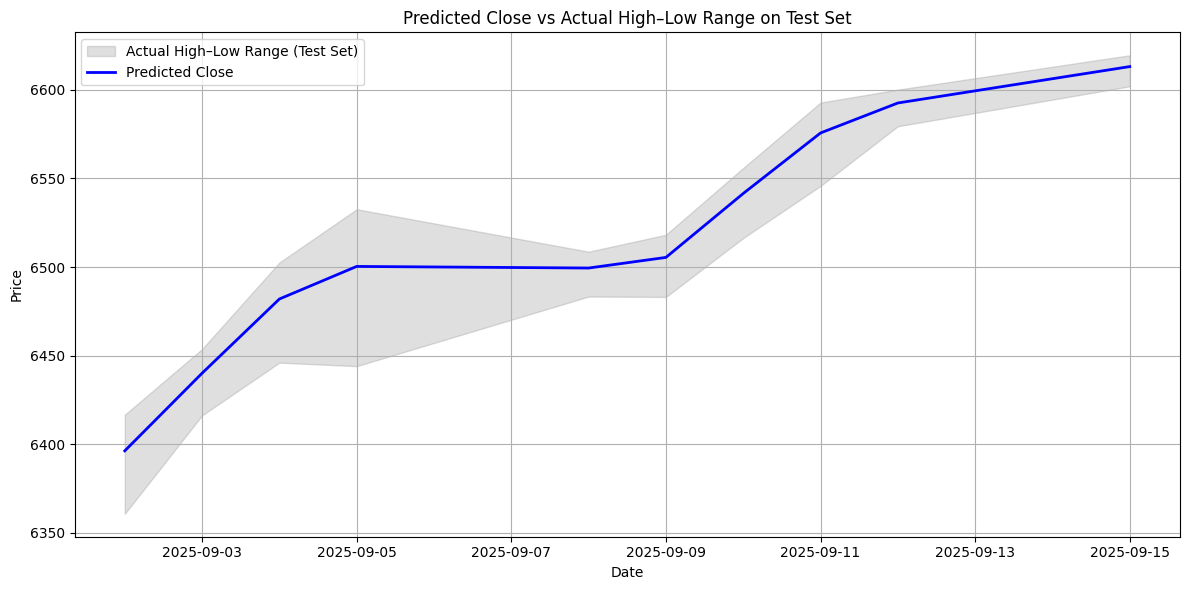

In [127]:
# Load the dataframes (assuming X_test.csv and predicted_close.csv exist)
try:
    test_df_plot = pd.read_csv("X_test.csv")
    pred_df_plot = pd.read_csv("predicted_close.csv")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure X_test.csv and predicted_close.csv exist.")
    exit()

# Convert 'Date' columns to datetime objects
test_df_plot['Date'] = pd.to_datetime(test_df_plot['Date'])
pred_df_plot['Date'] = pd.to_datetime(pred_df_plot['Date'])

# Merge the dataframes based on the 'Date' column for plotting
merged_df_for_plot = pd.merge(test_df_plot, pred_df_plot, on='Date', how='left')
merged_df_for_plot.sort_values('Date', inplace=True)

# Drop rows where actual High/Low or Predicted_Close might be missing (shouldn't happen if pipelines are aligned)
merged_df_for_plot.dropna(subset=['Low', 'High', 'Predicted_Close'], inplace=True)

plt.figure(figsize=(12,6))
# Plot the actual High-Low range as a shaded area
plt.fill_between(merged_df_for_plot['Date'],
                 merged_df_for_plot['Low'],
                 merged_df_for_plot['High'],
                 color='grey', alpha=0.25, label='Actual High–Low Range (Test Set)')
# Plot the predicted Close price
plt.plot(merged_df_for_plot['Date'], merged_df_for_plot['Predicted_Close'], color='blue', linewidth=2, label='Predicted Close')

plt.title('Predicted Close vs Actual High–Low Range on Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()